<a href="https://colab.research.google.com/github/Codenid/UTEC_2025_IA_FUNDAMENTALS/blob/main/TAREA/TAREA_2/Flow_Shop_Simulated_Annealing_Result.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Trabajos vs Maquinas = Tiempos
[[ 5.67447594  2.          2.          2.6318993   2.          2.79664525
   3.86365733  2.          5.08475799  2.        ]
 [ 2.          3.4758325   9.33882436  8.15398607  5.63025639  3.70041038
   2.          7.17645662 10.05668409  2.        ]
 [ 2.28448165  3.57449259  7.34120503  9.02561311  2.          2.
   5.63544043 10.50554371  4.23357518  4.57272555]
 [ 2.          2.          2.          2.          4.99495438  8.32483678
  13.66829027  2.889758    2.          6.490026  ]
 [ 2.         12.10454108  3.03184488  2.          2.         15.
   2.32726574 11.09960218  2.          2.48738032]
 [ 8.37547213  3.10752572  8.24085291  7.46037229  3.02489689  2.
   2.          9.43236144  4.64577139  9.44544419]
 [11.0642271   2.          8.08811965  2.          2.72674093  2.
   4.81164426  3.27282088  6.13602195  3.60906641]
 [ 3.96395445  2.          2.         15.          2.          4.54731868
   2.76180771  2.27165129  5.75148033  2.        ]
 

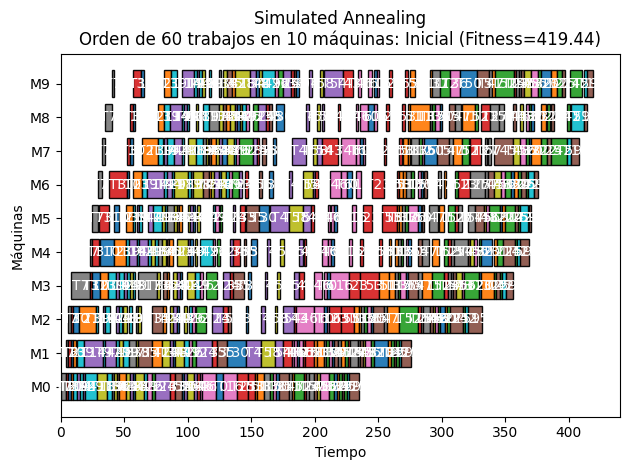

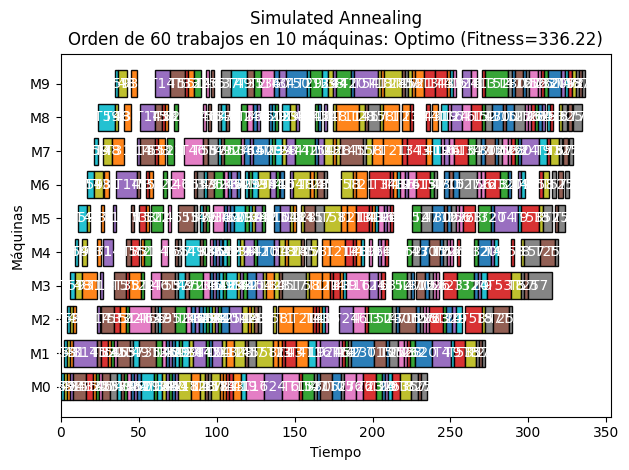

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Parámetros globales (predeterminados)
num_jobs = 60
num_machines = 10

# Paso 0: generación de la matriz de tiempos
def generar_matriz_aleatoria(
    num_filas, num_columnas,
    mean_time=4.0,
    minimo=2.0,
    maximo=15.0
):
    """
    Genera una matriz de tiempos de procesamiento aleatoria con distribución Exponencial
    recortada a [minimo, maximo].

    Parámetros:
    - num_filas: número de trabajos (filas).
    - num_columnas: número de máquinas (columnas).
    - mean_time: media de la Exponencial (1/λ).
    - minimo: tiempo mínimo permitido.
    - maximo: tiempo máximo permitido.
    """
    matriz_tiempos = np.random.exponential(scale=mean_time, size=(num_filas, num_columnas))
    np.clip(matriz_tiempos, minimo, maximo, out=matriz_tiempos)
    return matriz_tiempos

# Paso 1: cálculo de los tiempos de completado (DP)
def times_for_fitness(sol, tiempos_procesamiento):
    num_trabajos, num_maquinas = tiempos_procesamiento.shape
    matriz_tiempos = np.zeros((num_trabajos, num_maquinas), dtype=np.float32)
    for i, trabajo in enumerate(sol):
        for j in range(num_maquinas):
            if i == 0 and j == 0:
                matriz_tiempos[i, j] = tiempos_procesamiento[trabajo, j]
            elif i == 0:
                matriz_tiempos[i, j] = matriz_tiempos[i, j-1] + tiempos_procesamiento[trabajo, j]
            elif j == 0:
                matriz_tiempos[i, j] = matriz_tiempos[i-1, j] + tiempos_procesamiento[trabajo, j]
            else:
                matriz_tiempos[i, j] = max(
                    matriz_tiempos[i-1, j],
                    matriz_tiempos[i, j-1]
                ) + tiempos_procesamiento[trabajo, j]
    return matriz_tiempos

def fitness(sol, tiempos_procesamiento):
    """Makespan: tiempo de finalización del último trabajo en la última máquina."""
    return times_for_fitness(sol, tiempos_procesamiento)[-1, -1]

# Paso 2: generación de vecinos random
def random_neighbor(sol):
  i, j = np.random.choice(len(sol), 2, replace=False) # two random indices
  new_sol = sol.copy()
  new_sol[i], new_sol[j] = new_sol[j], new_sol[i]
  return new_sol

def accept(delta, T):
  if delta < 0:
    return True
  else: # damos la opcion de aceptar soluciones malas.
    r = np.random.rand() # random value between [0, 1]
    if r < np.exp(-delta/T):
      return True
    else:
      return False

# Paso 3: visualización Gantt
def plot_schedule(sol, tiempos_procesamiento, fitness_val, tipo, alpha=0.95):
    matriz_tiempos = times_for_fitness(sol, tiempos_procesamiento)
    num_maquinas = tiempos_procesamiento.shape[1]
    fig, ax = plt.subplots()
    for i, trabajo in enumerate(sol):
        for j in range(num_maquinas):
            inicio = matriz_tiempos[i, j] - tiempos_procesamiento[trabajo, j]
            duracion = tiempos_procesamiento[trabajo, j]
            ax.barh(y=j, width=duracion, left=inicio,
                    color=f"C{trabajo}", edgecolor="black", alpha=alpha)
            ax.text(inicio + duracion/2, j, f"T{trabajo}",
                    va="center", ha="center", color="white")
    ax.set_xlabel("Tiempo")
    ax.set_ylabel("Máquinas")
    ax.set_title(f"Simulated Annealing\nOrden de {len(sol)} trabajos en {num_maquinas} máquinas: {tipo} (Fitness={fitness_val:.2f})")
    ax.set_yticks(range(num_maquinas))
    ax.set_yticklabels([f"M{j}" for j in range(num_maquinas)])
    plt.tight_layout()
    plt.show()

# Paso 4: simulated-annealing
def simulated_annealing(sol, tiempos_procesamiento, T_max, T_min, cooling_rate):
  T = T_max
  x = sol.copy()
  E = fitness(x, tiempos_procesamiento)

  print("temperatura:", T)
  print("x", x)
  print("E", E, "\n")

  while (T > T_min) :
    x_new = random_neighbor(x)
    E_new = fitness(x_new, tiempos_procesamiento)
    delta = E_new - E
    #print("iteration, T:", T, " delta:", delta)
    if accept(delta, T):
      x = x_new
      E = E_new

    T = T*cooling_rate

  return x, E

tiempos_procesamiento = generar_matriz_aleatoria(num_jobs, num_machines)
print("Trabajos vs Maquinas = Tiempos")
print(tiempos_procesamiento)
print()

# Step 1
current_solution = np.arange(len(tiempos_procesamiento))
np.random.shuffle(current_solution)
fit_current = fitness(current_solution, tiempos_procesamiento)

print(
    f"Initial solution: {current_solution} - "
    f"Associated fitness: {fit_current:.2f}"
)

%time sol_opt, fit_opt = simulated_annealing(current_solution, tiempos_procesamiento, T_max=1000, T_min=0.000001, cooling_rate=0.95)

print(
    f"\nOptimal solution: {sol_opt} - "
    f"Associated fitness: {fit_opt:.2f}\n"
)

plot_schedule(current_solution, tiempos_procesamiento, fit_current, "Inicial")
plot_schedule(sol_opt, tiempos_procesamiento, fit_opt, "Optimo")

In [14]:
def run_flowshop_simulated_annealing(
    num_jobs, num_machines,
    mean_time=4.0, minimo=2.0, maximo=15.0,
    plot_interval=4, seed=None
):
    """
    Ejecuta hill-climbing para un flow-shop con num_jobs y num_machines.
    Retorna la solución óptima encontrada y su makespan.
    """
    if seed is not None:
        np.random.seed(seed)
    tiempos_procesamiento = generar_matriz_aleatoria(
        num_jobs, num_machines, mean_time, minimo, maximo
    )
    print("Trabajos vs Máquinas = Tiempos")
    print(tiempos_procesamiento)
    sol0 = np.arange(num_jobs)
    np.random.shuffle(sol0)
    print("\nSolución Inicial:", sol0)
    print(f"Fitness Inicial: {fitness(sol0, tiempos_procesamiento):.2f}\n")
    sol_opt, fit_opt = simulated_annealing(sol0, tiempos_procesamiento, T_max=1000, T_min=0.000001, cooling_rate=0.95)
    print(f"\nSolución Óptima: {sol_opt}")
    print(f"Fitness Óptimo: {fit_opt:.2f}")
    plot_schedule(sol_opt, tiempos_procesamiento, fit_opt, "Optimo")
    return sol_opt, fit_opt

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]]

Solución Inicial: [0 2 3 4 1]
Fitness Inicial: 64.81

temperatura: 1000
x [0 2 3 4 1]
E 64.809845 


Solución Óptima: [3 0 4 1 2]
Fitness Óptimo: 56.54


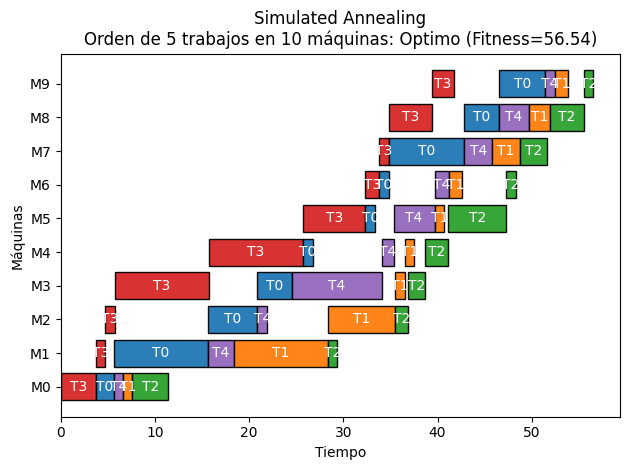

(array([3, 0, 4, 1, 2]), np.float32(56.54212))

In [16]:
number_of_jobs = 5

run_flowshop_simulated_annealing(
    num_jobs=number_of_jobs,
    num_machines=10,
    mean_time=4.0,
    minimo=1.0,
    maximo=10.0,
    plot_interval=2,
    seed=42
)

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]
 [10.          5.96898151 10.          9.00860799  3.64421765 10.
   1.          1.          1.          1.57412835]]

Solución Inicial: [3 5 0 2 1 4]
Fitness Inicial: 76.10

temperatura: 1000
x [3 5 0 2 1 4]
E 76.10145 


Solución Óptima: [4 3 1 0 2 5]
Fitness Óptimo: 69.94


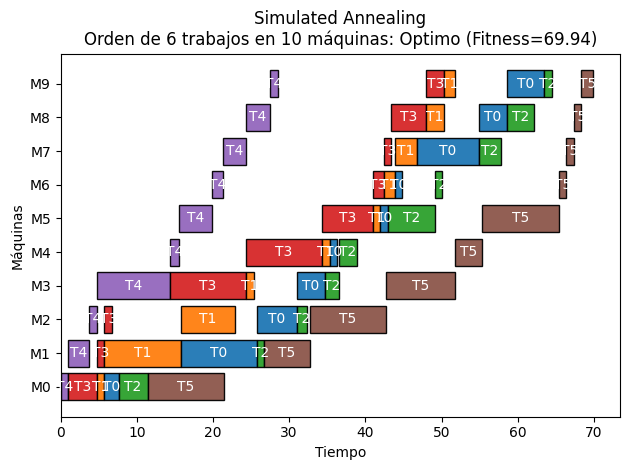

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025  1.         10.
   7.14571817  1.          1.          1.          1.45101492  2.97571132
   2.26214827  1.37689197  3.7854835   1.          1.38206205  1.82510887
   2.43573875  6.15174404  1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337  1.          2.73418891
   1.          9.60169155  1.19783111  4.34502319  1.49418633  2.93644358
   3.16489519  1.         10.          5.96898151 10.          9.00860799
   3.64421765 10.          1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.          5.9179351   1.
   1.          6.75958711  4.90838363  5.22265164  5.9008581   1.
   1.77557069  1.          7.95411829

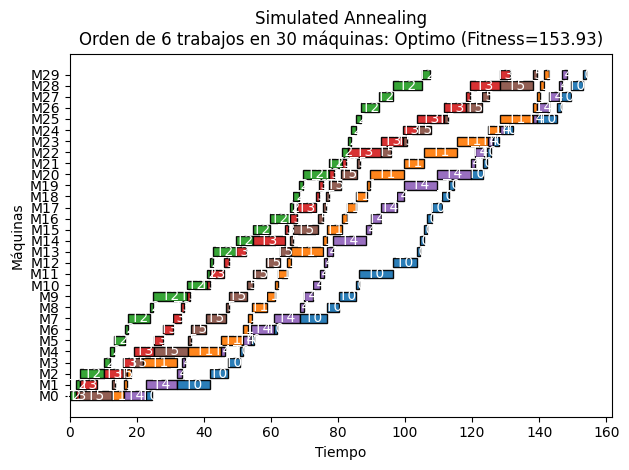

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025  1.         10.
   7.14571817  1.          1.          1.          1.45101492  2.97571132
   2.26214827  1.37689197  3.7854835   1.          1.38206205  1.82510887
   2.43573875  6.15174404  1.          2.88811662  3.59001889  1.
   3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337  1.          2.73418891
   1.          9.60169155  1.19783111  4.34502319  1.49418633  2.93644358
   3.16489519  1.         10.          5.96898151 10.          9.00860799
   3.64421765 10.          1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.          5.9179351   1.
   1.          6.75958711  4.90838363  5.22265164  5.9008581   1.
   1.77557069  1.          7.95411829  3.90520

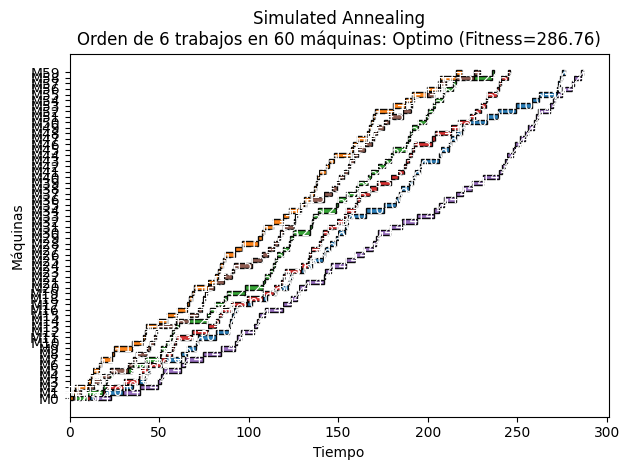

In [17]:
solutions_dict = {}

for number_of_machines in [10,30,60]:
    solucion_optima, fitness_sol = run_flowshop_simulated_annealing(
            num_jobs=6,
            num_machines=number_of_machines,
            mean_time=4.0,
            minimo=1.0,
            maximo=10.0,
            plot_interval=2,
            seed=42
        )

    solutions_dict[number_of_machines] = {
        "solucion_optima": solucion_optima,
        "fitness": fitness_sol
    }

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]
 [10.          5.96898151 10.          9.00860799  3.64421765 10.
   1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.        ]
 [ 5.9179351   1.          1.          6.75958711  4.90838363  5.22265164
   5.9008581   1.          1.77557069  1.   

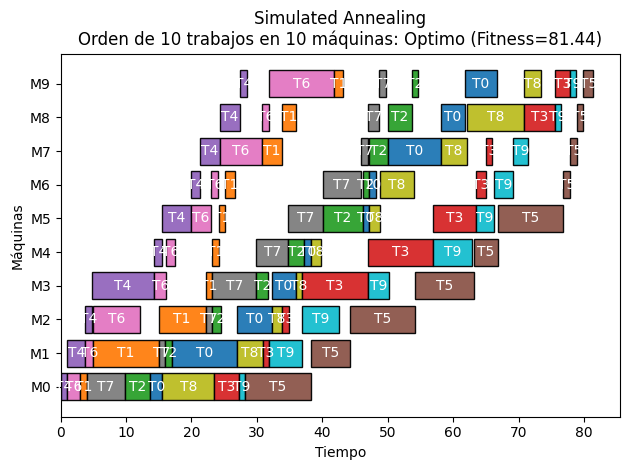

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]
 [10.          5.96898151 10.          9.00860799  3.64421765 10.
   1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.        ]
 [ 5.9179351   1.          1.          6.75958711  4.90838363  5.22265164
   5.9008581   1.          1.77557069  1.   

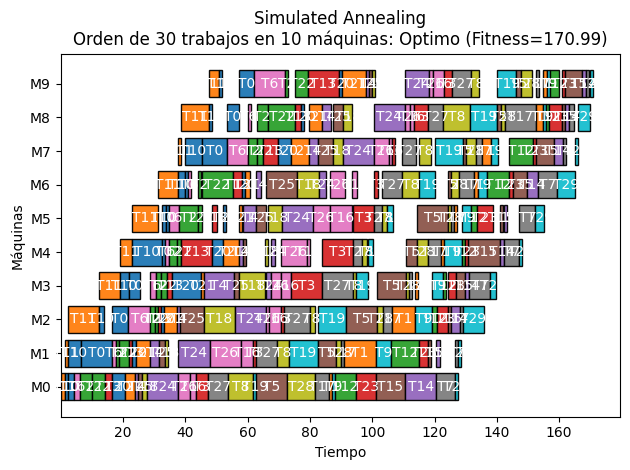

Trabajos vs Máquinas = Tiempos
[[ 1.87707236 10.          5.26698277  3.65177022  1.          1.
   1.          8.04492346  3.67632861  4.92500025]
 [ 1.         10.          7.14571817  1.          1.          1.
   1.45101492  2.97571132  2.26214827  1.37689197]
 [ 3.7854835   1.          1.38206205  1.82510887  2.43573875  6.15174404
   1.          2.88811662  3.59001889  1.        ]
 [ 3.74133208  1.          1.         10.         10.          6.60932629
   1.45315144  1.          4.61100305  2.32036337]
 [ 1.          2.73418891  1.          9.60169155  1.19783111  4.34502319
   1.49418633  2.93644358  3.16489519  1.        ]
 [10.          5.96898151 10.          9.00860799  3.64421765 10.
   1.          1.          1.          1.57412835]
 [ 1.96852117  1.26624177  7.05823146  1.764908    1.31921136  3.12962833
   1.          6.48193438  1.         10.        ]
 [ 5.9179351   1.          1.          6.75958711  4.90838363  5.22265164
   5.9008581   1.          1.77557069  1.   

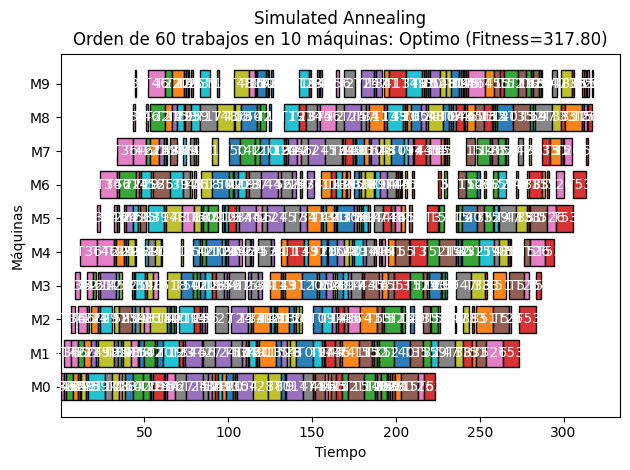

In [18]:
solutions_dict = {}

for number_of_jobs in [10,30,60]:
    solucion_optima, fitness_sol = run_flowshop_simulated_annealing(
            num_jobs=number_of_jobs,
            num_machines=10,
            mean_time=4.0,
            minimo=1.0,
            maximo=10.0,
            plot_interval=2,
            seed=42
        )

    solutions_dict[number_of_jobs] = {
        "solucion_optima": solucion_optima,
        "fitness": fitness_sol
    }